In [4]:
from fastai.vision.all import *
import gc

In [6]:
PATH = (r'')
TRAIN_PATH = (r'')
TEST_PATH = (r'')
CLASSES_PATH = (r'')

In [7]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.head()

,image_name,labels,is_valid
0,img\Sheer_Pleated-Front_Blouse\img_00000002.jpg,"pleated,sheer",0.0
1,img\Sheer_Pleated-Front_Blouse\img_00000003.jpg,"chic,pleated",1.0
2,img\Sheer_Pleated-Front_Blouse\img_00000006.jpg,pleated,1.0
3,img\Sheer_Pleated-Front_Blouse\img_00000009.jpg,"sheer,sophisticated",0.0
4,img\Sheer_Pleated-Front_Blouse\img_00000010.jpg,"relaxed,sheer,woven",0.0


In [8]:
def get_x(r): return PATH+r['image_name']
def get_y(r): return r['labels'].split(',')

In [9]:
def splitter(df):
    train = df.index[df['is_valid']==0].tolist()
    valid = df.index[df['is_valid']==1].tolist()
    return train,valid

In [10]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(224, min_scale=0.8),
                   batch_tfms=aug_transforms())

dls = dblock.dataloaders(train_df, num_workers=0)

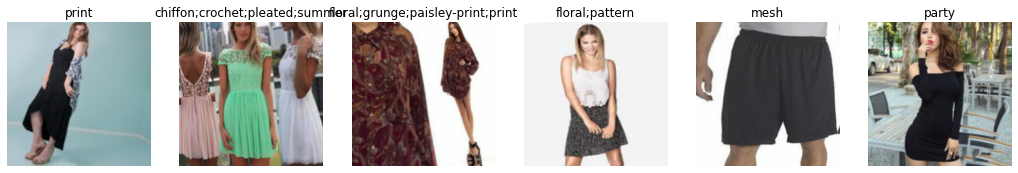

In [10]:
dls.show_batch(nrows=1, ncols=6)

## The choice of the evaluation metric

In [11]:
dsets = dblock.datasets(train_df)

In [12]:
dsets.train[0]

(PILImage mode=RGB size=205x300,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [13]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [14]:
number_of_classes = len(dsets.train[0][1])
fake_prediction = torch.tensor([[0.0] * number_of_classes])
fake_prediction

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [15]:
target = dsets.train[0][1].reshape(1,-1)
accuracy_multi(fake_prediction, target,  thresh=0.5, sigmoid=True)

TensorMultiCategory(0.9796)

accuracy_multi 를 사용할 경우 모델이 예측에 실패해도 97% 정확도라고 나오는듯..?
그래서 대신에 FBeta를 써보자

In [16]:
from sklearn.metrics import fbeta_score
fbeta_score(fake_prediction, target, beta=2, average='samples')

0.0

In [17]:
# create a random prediction
import random
random_list = [0.0]*int(number_of_classes/2) + [1.0]*int(number_of_classes/2)
random.shuffle(random_list)
fake_prediction = torch.tensor([random_list])
fake_prediction

tensor([[1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
         0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
         0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 1., 0., 1., 1., 0., 0.]])

In [18]:
fbeta_score(fake_prediction, target, beta=2, average='samples')

0.0

In [20]:
# create a perfect prediction where prediction=target
fbeta_score(fake_target, target, beta=2, average='samples')

NameError: name 'fake_target' is not defined

## The choice of the loss Function

In [21]:
dsets.train[0]

(PILImage mode=RGB size=205x300,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [11]:
dls.vocab

['abstract-print', 'animal', 'baroque', 'basic', 'beach', 'bird-print', 'boho', 'botanical-print', 'camouflage', 'cargo', 'chic', 'chiffon', 'circle', 'civil', 'colorblock', 'cotton', 'cozy', 'crochet', 'cute', 'denim', 'dotted', 'elegant', 'everyday', 'fancy', 'faux-fur', 'faux-leather', 'faux-suede', 'feather', 'floral', 'fur', 'glitter', 'graphic', 'grid-print', 'grunge', 'knotted', 'leaf-print', 'leather', 'leopard-print', 'linen', 'linen-blend', 'logo', 'luxe', 'marble-print', 'medallion-print', 'mesh', 'metallic', 'mixed-print', 'multi-stripe', 'neon', 'neoprene', 'nets', 'netted', 'nylon', 'oil', 'ombre', 'organza', 'ornate-print', 'paisley-print', 'palm-print', 'party', 'patched', 'pattern', 'pleated', 'print', 'relaxed', 'retro', 'safari', 'sateen', 'satin', 'sheer', 'smart', 'soft', 'solid', 'sophisticated', 'sparkling', 'sporty', 'springs', 'square', 'star', 'strap', 'stretch', 'striped', 'suede', 'summer', 'sweet', 'textured', 'thermal', 'tie-dye', 'training', 'triangle', '

In [12]:
len(dls.vocab)

98

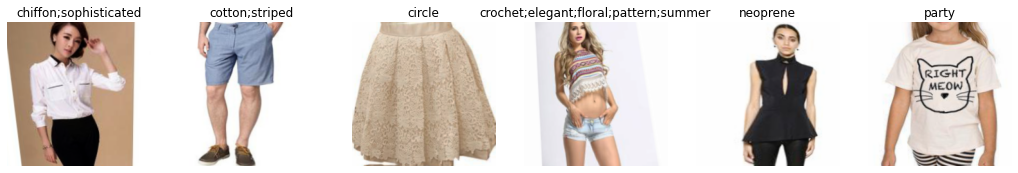

In [23]:
dls.show_batch(nrows=1, ncols=6)

In [24]:
class LabelSmoothingBCEWithLogitsLossFlat(BCEWithLogitsLossFlat):
    def __init__(self, eps:float=0.1, **kwargs):
        self.eps = eps
        super().__init__(thresh=0.2, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        # https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/166833#929222
        targ_smooth = targ.float() * (1. - self.eps) + 0.5 * self.eps
        return super().__call__(inp, targ_smooth, **kwargs)
    
    def __repr__(self):
        return "FlattenedLoss of LabelSmoothingBCEWithLogits()"

In [25]:
metrics=[FBetaMulti(2.0, 0.2, average='samples'), partial(accuracy_multi, thresh=0.2)]

In [26]:
wd      = 5e-7 #weight decay parameter
opt_func = partial(ranger, wd=wd)

In [27]:
learn = cnn_learner(dls, resnet34, loss_func=BCEWithLogitsLossFlat(thresh=0.2),
            metrics=metrics, opt_func=opt_func).to_fp16()

In [28]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.059611,0.053688,0.328084,0.983208,10:38


epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.052106,0.048477,0.408241,0.984199,11:31
1,0.048909,0.046856,0.427322,0.984407,11:29


In [29]:
learn = cnn_learner(dls, resnet34, loss_func=LabelSmoothingBCEWithLogitsLossFlat(),
        metrics=metrics, opt_func=opt_func).to_fp16()

In [ ]:
learn.fine_tune(2)
learn.save('resnet34_stage_1')

## Discriminative Learning Rates

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=9.12010818865383e-07)

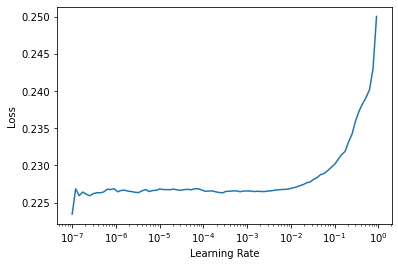

In [31]:
learn.unfreeze()
learn.lr_find()

In [32]:
learn.fit_one_cycle(8, lr_max=slice(5e-7, 1e-4))

epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.226144,0.224673,0.432184,0.983483,11:18
1,0.225968,0.224598,0.435978,0.983466,11:13
2,0.225563,0.224519,0.439531,0.983505,11:13
3,0.225829,0.224439,0.441547,0.983445,11:21
4,0.225798,0.224360,0.442245,0.983699,11:21
5,0.225480,0.224342,0.443197,0.983657,11:09
6,0.225655,0.224357,0.443530,0.983628,11:09
7,0.225364,0.224342,0.442560,0.983754,11:16


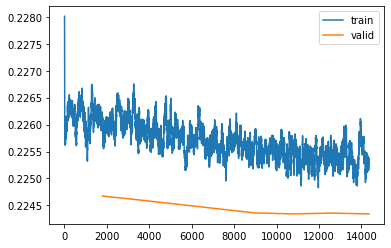

In [33]:
learn.recorder.plot_loss()

In [34]:
learn.save('resnet34_stage_2')

modelname = learn.model
modelname.cpu()
torch.save(modelname, 'resnet34_stage_2.pkl')

with open(CLASSES_PATH, 'w') as f:
    for item in dls.vocab:
        f.write("%s\n" % item)

# Evaluation

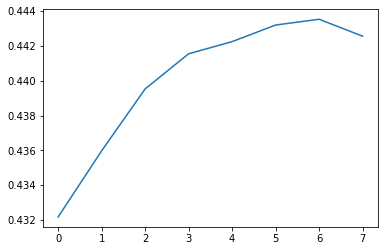

In [35]:
plt.plot(L(learn.recorder.values).itemgot(2))

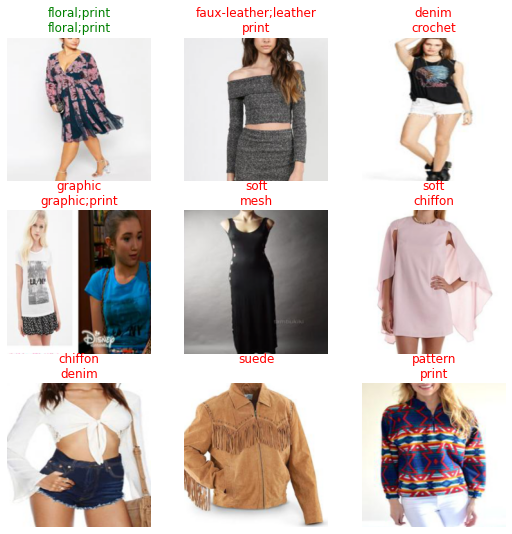

In [36]:
# training dataset
learn.show_results()

In [38]:
# test dataset
test_df = pd.read_csv(TEST_PATH)
test_df.head()

,image_name,labels
0,img\Sheer_Pleated-Front_Blouse\img_00000005.jpg,"feather,pleated"
1,img\Sheer_Pleated-Front_Blouse\img_00000007.jpg,"pleated,sheer"
2,img\Sheer_Pleated-Front_Blouse\img_00000013.jpg,sheer
3,img\Sheer_Pleated-Front_Blouse\img_00000019.jpg,pleated
4,img\Sheer_Pleated-Front_Blouse\img_00000020.jpg,sheer


In [39]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(224)) 

test_dls = dblock.dataloaders(test_df, num_workers=0)

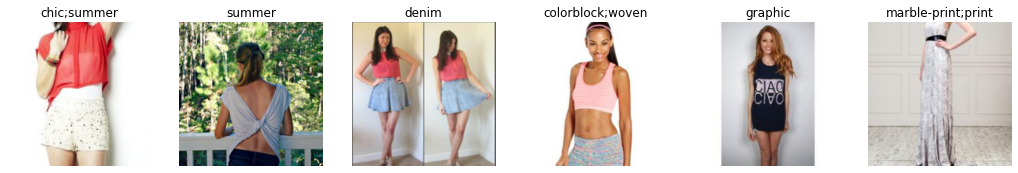

In [40]:
test_dls.show_batch(nrows=1, ncols=6)

In [41]:
learn.data = test_dls
learn.validate()

(#3) [0.22434164583683014,0.4425602782765178,0.9837535619735718]

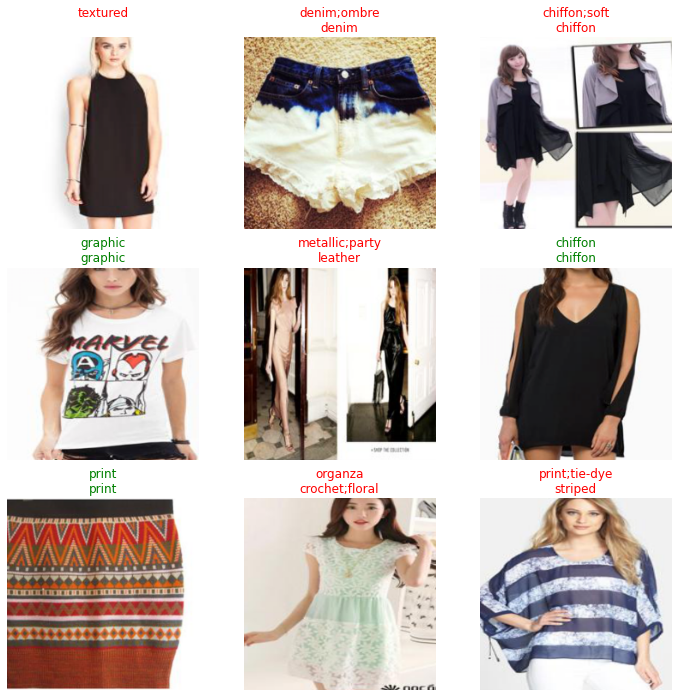

In [42]:
learn.show_results(figsize=(12,12))

In [43]:
def predict_attribute(model, path, display_img=True):
    predicted = model.predict(path)
    if display_img:
        size = 244,244
        img=Image.open(path)
        img.thumbnail(size,Image.ANTIALIAS)
        display(img)
    return predicted[0]

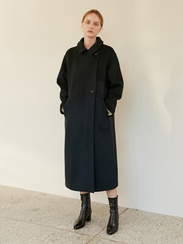

(#1) ['denim']

In [52]:
image_path = (r'') # 예측할 이미지 경로
predict_attribute(learn, image_path)